In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

# Read and sanitize the data
df = pd.read_csv("../data/t00/export/data__t00_prop.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
from core.utils.preprocessing import df_to_xydf, df_to_xy

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


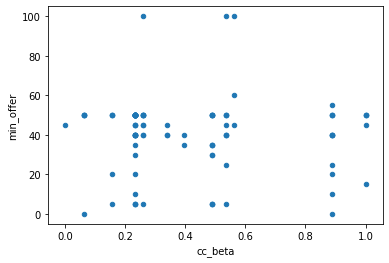

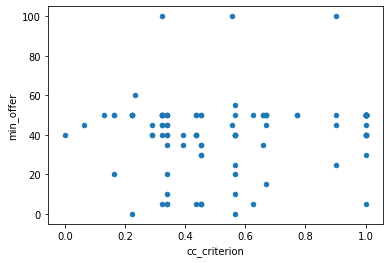

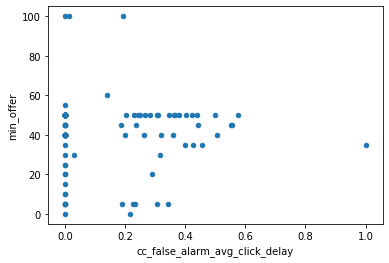

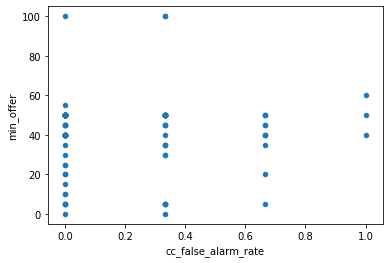

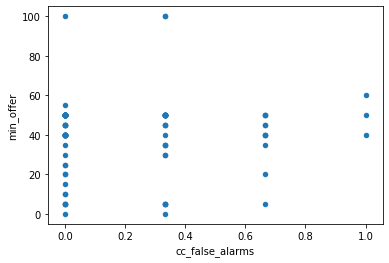

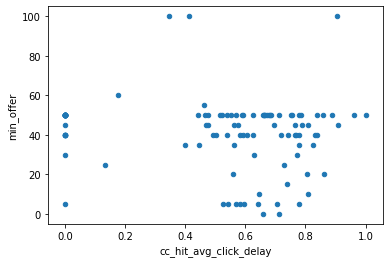

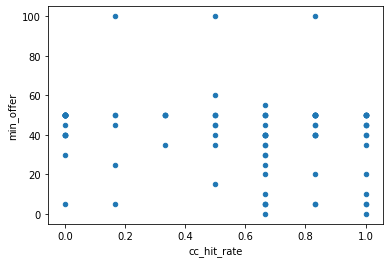

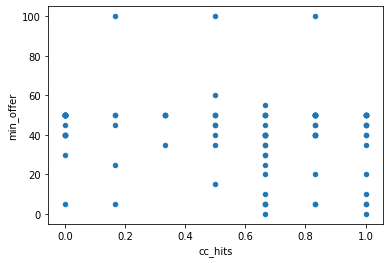

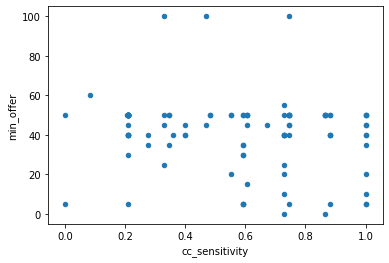

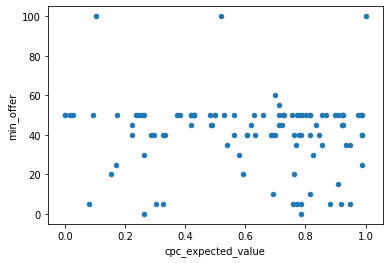

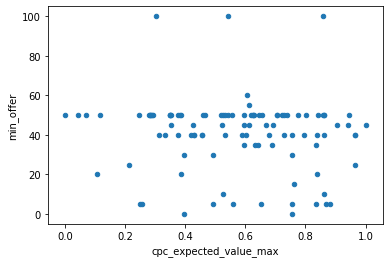

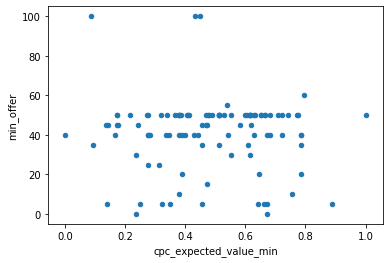

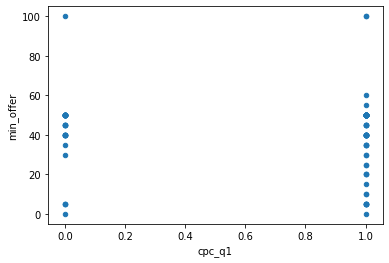

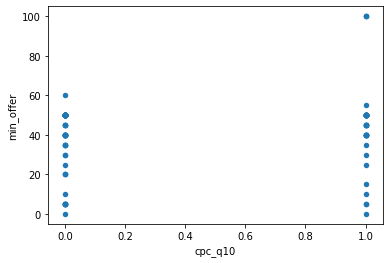

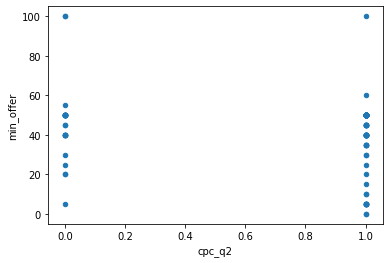

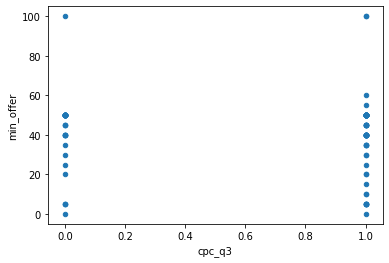

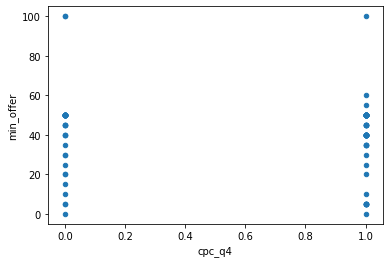

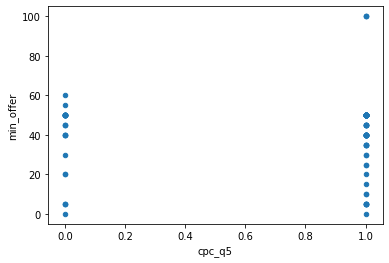

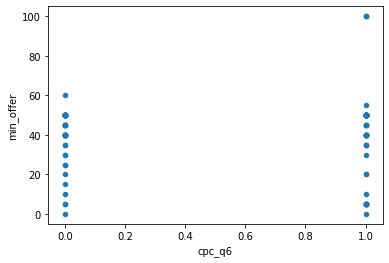

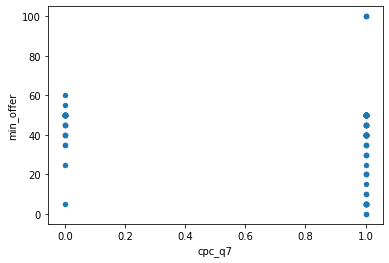

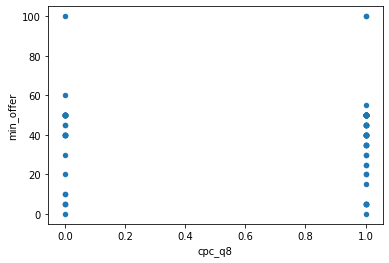

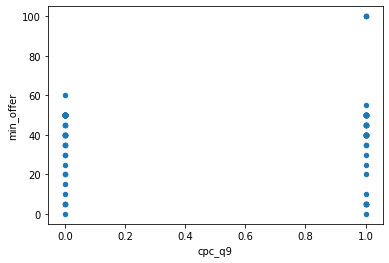

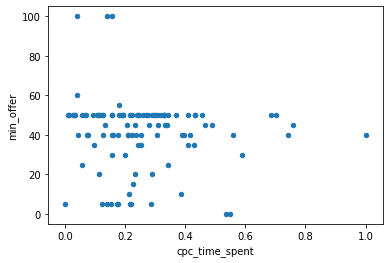

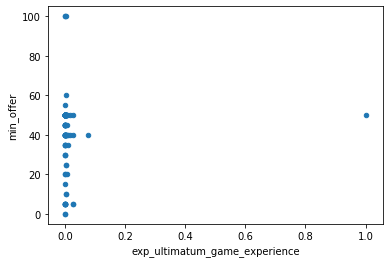

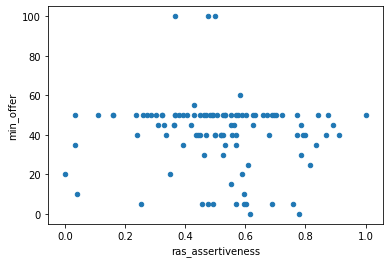

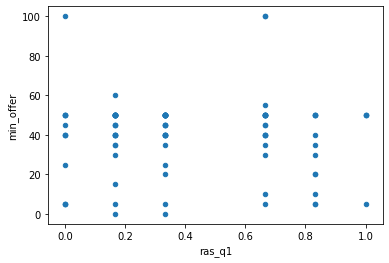

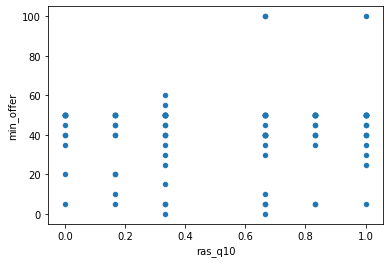

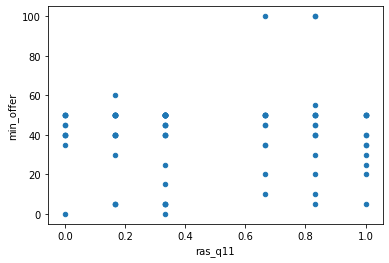

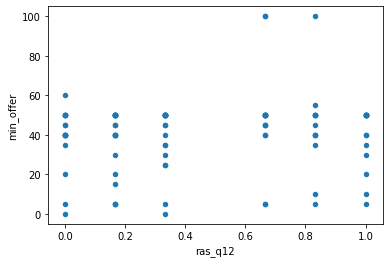

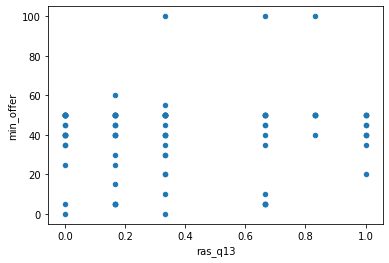

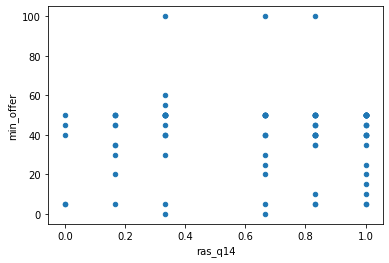

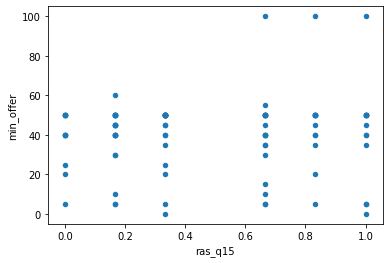

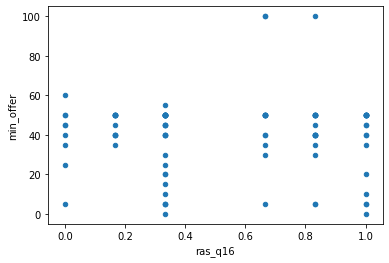

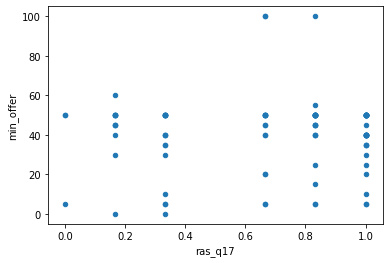

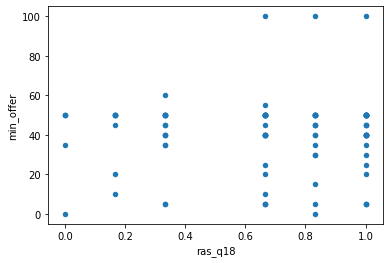

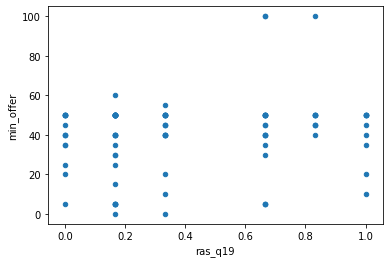

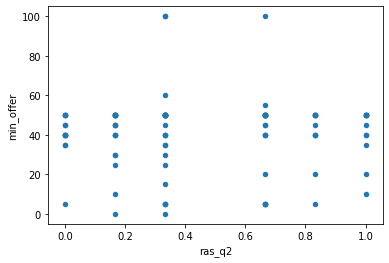

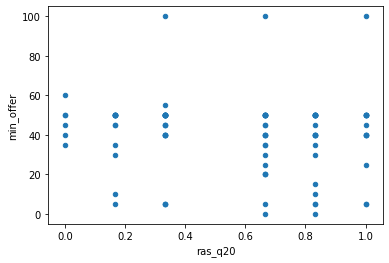

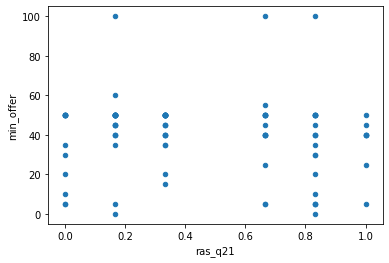

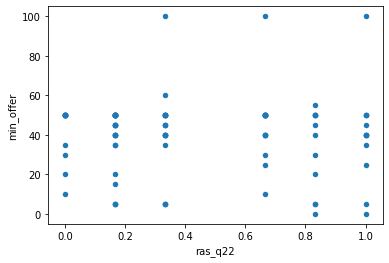

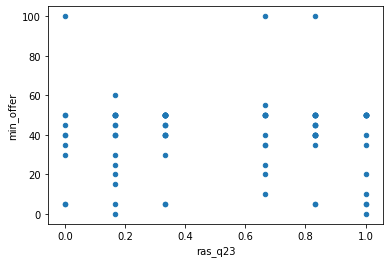

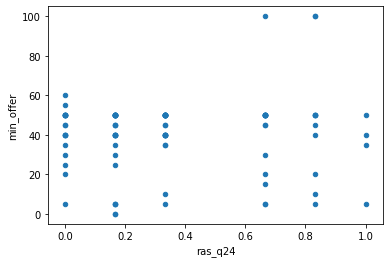

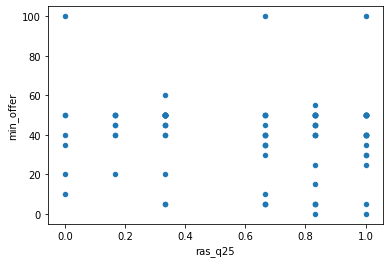

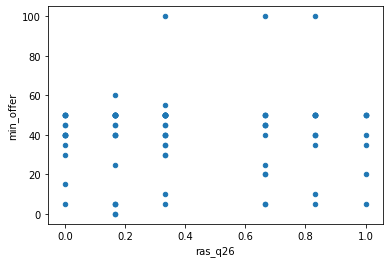

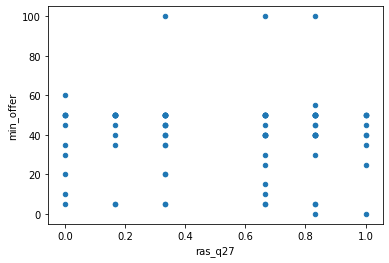

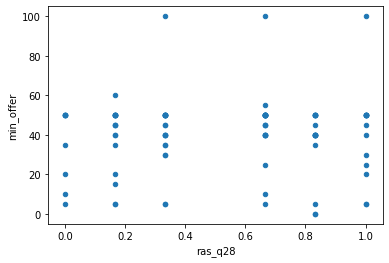

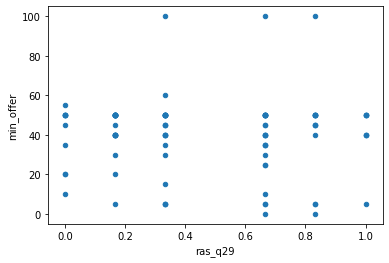

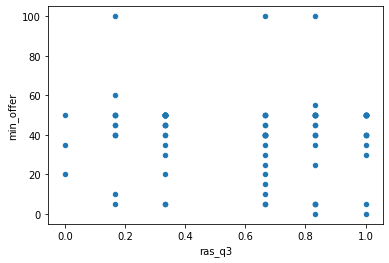

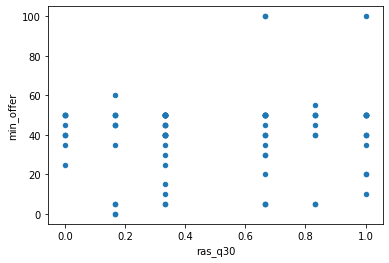

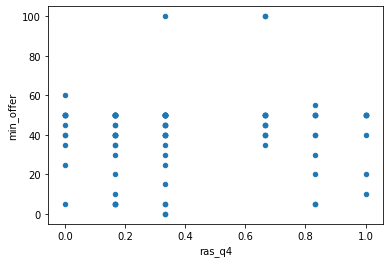

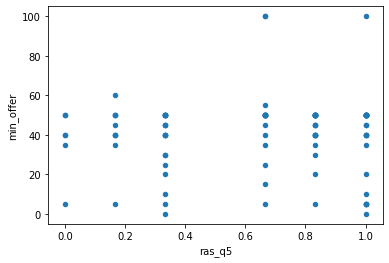

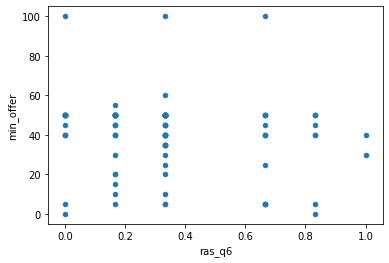

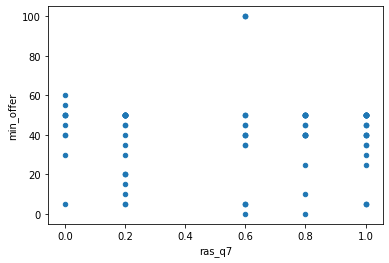

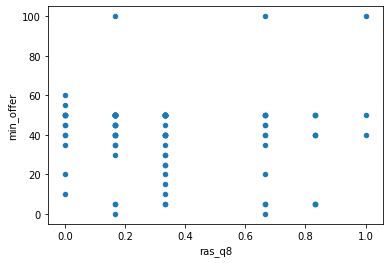

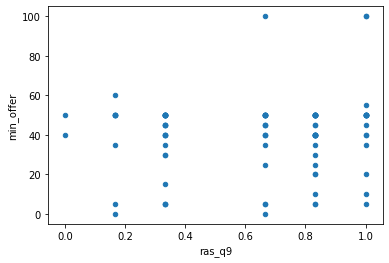

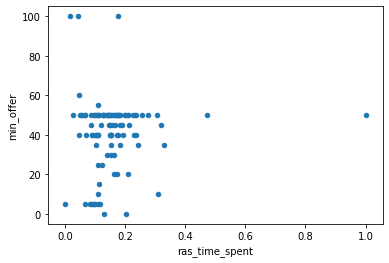

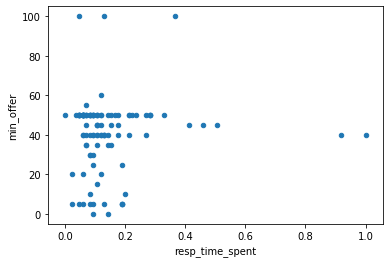

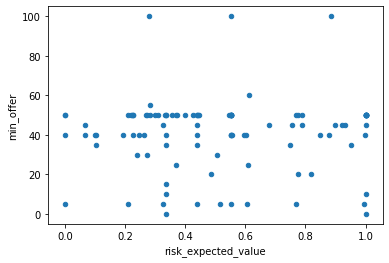

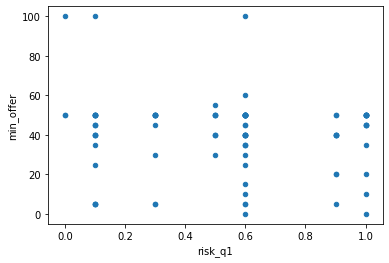

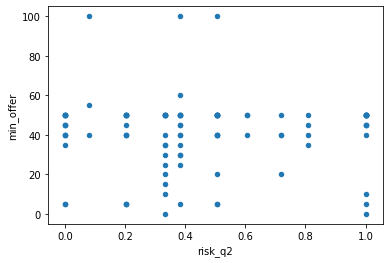

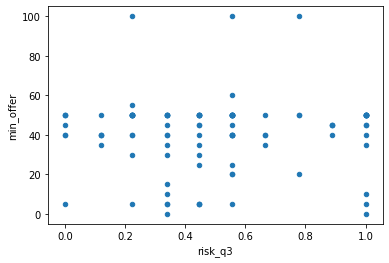

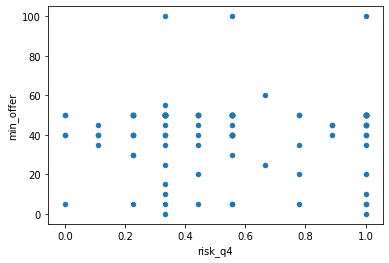

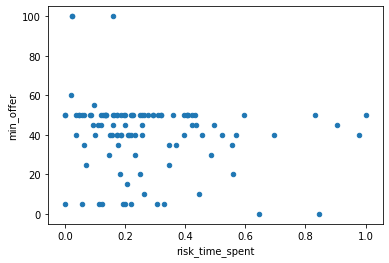

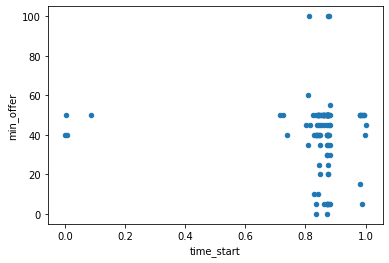

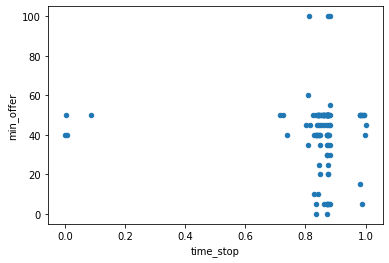

In [3]:
all_cols = list(df.columns)
if 'min_offer' in all_cols:
    all_cols.remove('min_offer')
for col in all_cols:
    if col == 'effort':
        x, y = df_to_xy(df, select_columns=[col])
    else:
        x, y = df_to_xy(df, select_columns=[col])
    x = x.ravel()
    y = y.ravel()
    out_df = pd.DataFrame.from_dict({col:x, 'min_offer':y})
    out_df.plot.scatter(x=col, y='min_offer')

In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from core.models import AcceptanceModel
from core.models.deep import KerasModel

split = int(x.shape[0] * 0.75)
xTrain = x[:split].reshape(-1, 1)
yTrain = y[:split]
xTest = x[split:].reshape(-1, 1)
yTest = y[split:]
model = KerasModel()
model.fit(xTrain, yTrain)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
yPred = model.predict(xTest)
yPred

raw_pred:  [54.322865 54.322865 54.322865 54.322865 54.322865 54.322865 54.322865
 54.322865 54.322865 54.322865 54.322865 54.322865 54.322865 54.322865
 54.322865 54.322865 54.322865 54.322865 54.322865 54.322865 54.322865
 54.322865 54.322865 54.322865 54.322865 54.322865 54.322865]


array([55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55.], dtype=float32)

In [6]:
yTest

array([  5,  40,  50,  25,  50,  40,  50,  50, 100,   5,  55,  45,  35,
        50,  45,  30,  50,  50,  15,  50,   5,  50,  50,  50,  50,  40,
        45])

In [7]:
from core.models.metrics import gain_mean, avg_loss_ratio
print("loss ratio: ", avg_loss_ratio(yTest, yPred))
gain_mean(yTest, yPred)

loss ratio:  0.24480834496314385


43.333333333333336

In [8]:
import numpy as np
import pandas as pd
from core.models.metrics import loss

@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss_derivable(x, offset=1,  div1=8, div2=20):
    x1 = (x + offset) / div1
    x2 = (x) / div2
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain_derivable(x):
    return 1 - loss(x)

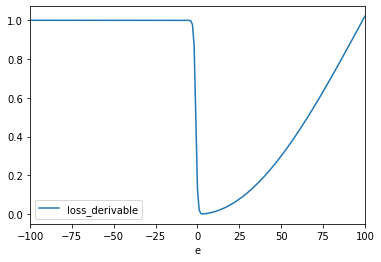

In [9]:
x = np.arange(-100, 101, 1)
y_derivable = loss_derivable(x)

out_df = pd.DataFrame({'e':x, 'loss_derivable':y_derivable})
out_df.plot.line(x='e', y='loss_derivable')

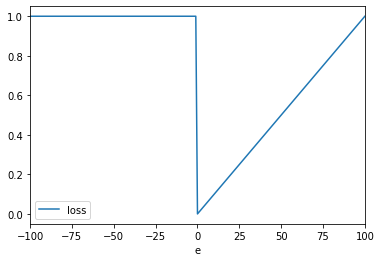

In [10]:
x = np.arange(-100, 101, 1)
y = loss(0, x) / 100

out_df = pd.DataFrame({'e':x, 'loss':y})
out_df.plot.line(x='e', y='loss')

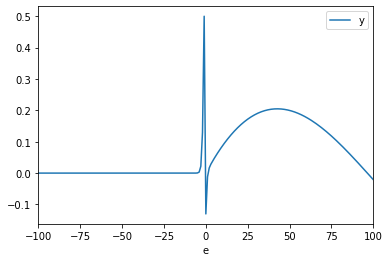

In [11]:
tmp_df = pd.DataFrame({'e':x, 'y': y - y_derivable})
tmp_df.plot.line(x='e', y='y')

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/lib/polynomial.py:626: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


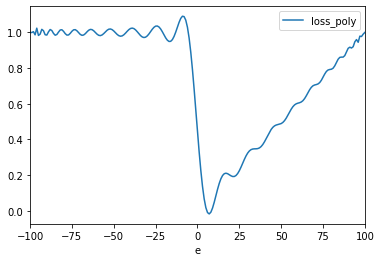

In [12]:
degs = np.polyfit(x, y, deg=150)
loss_poly = np.poly1d(degs)
y_poly = loss_poly(x)
tmp2_df = pd.DataFrame({'e':x, 'loss_poly': y_poly})
tmp2_df.plot.line(x='e', y='loss_poly')

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt